# 11wk-2: 순환신경망 (1) – 임베딩 공간(Embedding Space)의 이해

최규빈  
2024-05-15

<a href="https://colab.research.google.com/github/guebin/DL2024/blob/main/posts/11wk-2.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" style="text-align: left"></a>

# 1. 강의영상

In [1]:
#{{<video https://youtu.be/playlist?list=PLQqh36zP38-xl7f2bcPTKMVCe3kHM380M&si=5SO7pni3fXX4kK-4 >}}

# 2. Imports

In [2]:
import torch
import pandas as pd
import matplotlib.pyplot as plt

In [367]:
def plot(y,yhat,title=None):
    plt.plot(y[:5],'o', label=r'$y$')
    plt.plot(yhat[:5],'X',markersize=10,alpha=0.5, label=r'$\hat{y}$')
    plt.legend()
    plt.title(title)

`-` 활성화함수들

In [1554]:
soft = torch.nn.Softmax(dim=1)
tanh = torch.nn.Tanh()
ohot = torch.nn.functional.one_hot

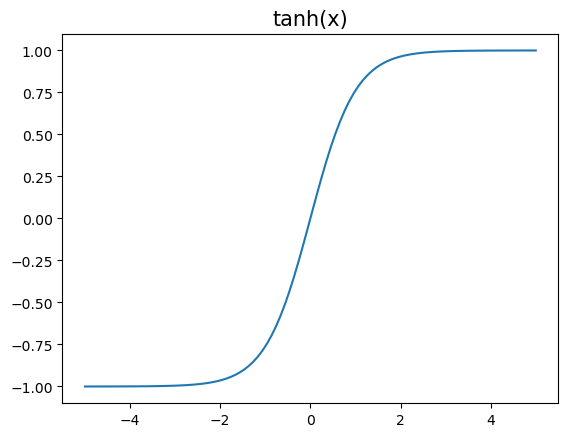

In [653]:
x = torch.linspace(-5,5,100)
plt.plot(x,tanh(x))
plt.title("tanh(x)", size=15)

# 3. `abc`

## A. Data

In [1529]:
txt = list('abc')*100
txt[:10]

In [1530]:
df_train = pd.DataFrame({'x':txt[:-1],'y':txt[1:]})
df_train[:5]

In [1531]:
x = torch.tensor(df_train.x.map({'a':0, 'b':1, 'c':2}))
y = torch.tensor(df_train.y.map({'a':0, 'b':1, 'c':2}))

## B. MLP – 하나의 은닉노드

In [1532]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=1),
    torch.nn.Tanh(), # 이거 씁시당. 외우세여
    torch.nn.Linear(in_features=1,out_features=3),
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [1533]:
for epoc in range(50):
    ## 1
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

In [1534]:
yhat = soft(net(x)).data
yhat.argmax(axis=1), y # 퍼펙트??

## C. 적합결과의 해석 ($\star$)

`-` 네트워크 분해

In [1555]:
ebdd,tanh,linr = net

`-` ebdd 레이어 통과직후

In [1565]:
ebdd_x = ebdd(x).data[:9]
ebdd_x

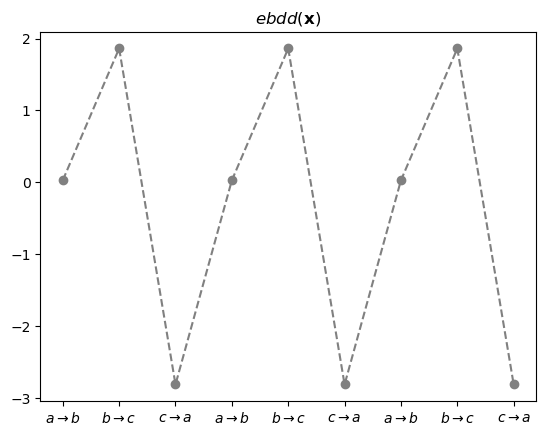

In [1558]:
plt.plot(ebdd_x,'--o',color="gray")
plt.title(r"$ebdd({\bf x})$");
plt.xticks(range(9),[r'$a\to b$',r'$b\to c$',r'$c \to a$']*3);

`-` (ebdd -\> tanh) 레이어 통과직후

In [1567]:
ebdd_x = ebdd(x).data[:9]
h = tanh(ebdd(x)).data[:9]
torch.concat([ebdd_x,h],axis=1)

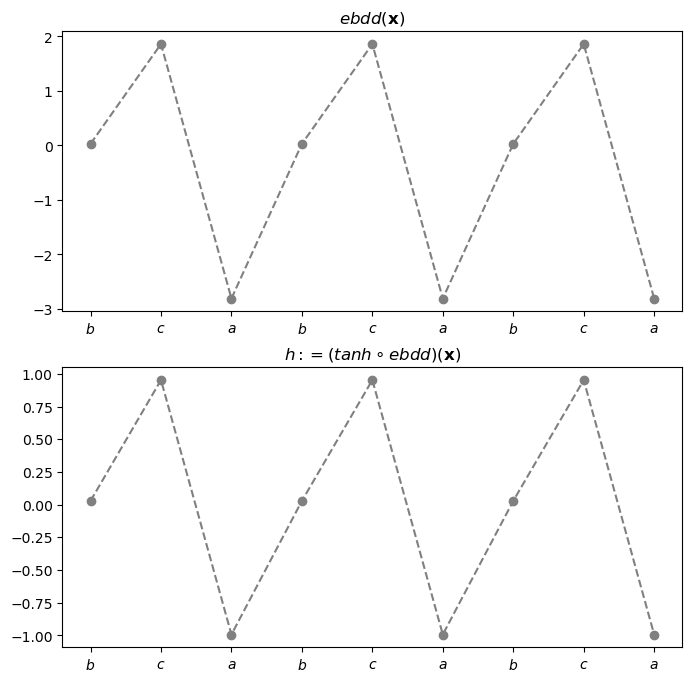

In [1568]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
ax[0].plot(ebdd_x,'--o',color="gray")
ax[0].set_title(r"$ebdd({\bf x})$")
ax[0].set_xticks(range(9),[r'$b$',r'$c$',r'$a$']*3);
ax[1].plot(h,'--o',color="gray")
ax[1].set_title(r"$h:=(tanh\circ ebdd)({\bf x})$");
ax[1].set_xticks(range(9),[r'$b$',r'$c$',r'$a$']*3);

-   여기까지 2개는 세트로 봐도 무방할듯
-   결과를 ${\boldsymbol h}$로 생각하자.

`-` (임베딩 -\> tanh -\> linr) 통과직후 – 여기에서 차원이 3차원으로
된다.

In [1569]:
ebdd_x = ebdd(x).data[:9]
h = tanh(ebdd(x)).data[:9]
netout = linr(tanh(ebdd(x))).data[:9]
torch.concat([ebdd_x,h,netout],axis=1)

In [1574]:
netout_a = netout[:,[0]]
netout_b = netout[:,[1]]
netout_c = netout[:,[2]]

In [1575]:
linr.weight, linr.bias

In [1576]:
netout_a, h*(-3.8416)+(-1.2536)

-   값이 살짝 다른이유는 Appendix 참고
-   여기서는 그냥 “똑같은결과가 나왔다” 라고 생각하고 넘어가자

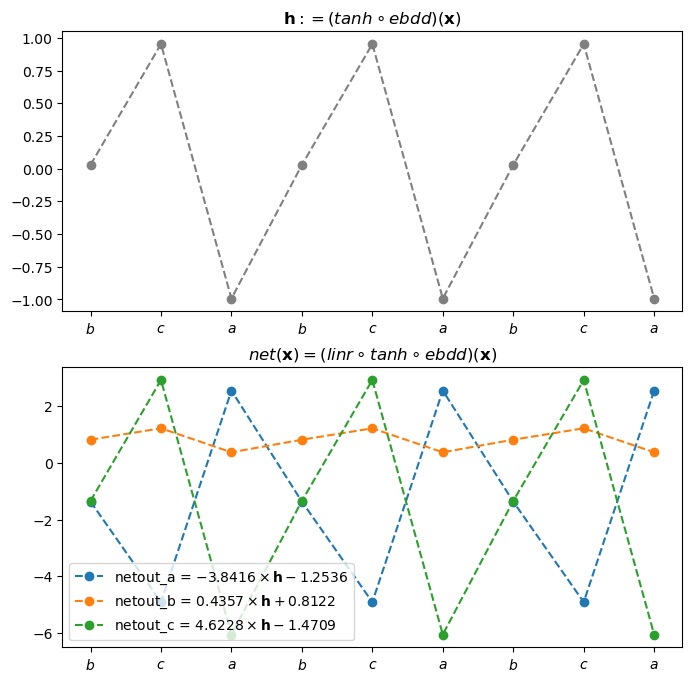

In [1578]:
fig, ax = plt.subplots(2,1,figsize=(8,8))
ax[0].plot(h,'--o',color="gray")
ax[0].set_title(r"${\bf h}:=(tanh\circ ebdd)({\bf x})$");
ax[0].set_xticks(range(9),[r'$b$',r'$c$',r'$a$']*3);
ax[1].plot(netout_a,'--o',color="C0",label=r"netout_a = $-3.8416\times {\bf h} - 1.2536$")
ax[1].plot(netout_b,'--o',color="C1",label=r"netout_b = $0.4357\times {\bf h} + 0.8122$")
ax[1].plot(netout_c,'--o',color="C2",label=r"netout_c = $4.6228\times {\bf h} - 1.4709$")
ax[1].set_xticks(range(9),[r'$b$',r'$c$',r'$a$']*3);
ax[1].legend()
ax[1].set_title(r"$net({\bf x})=(linr \circ tanh \circ ebdd)({\bf x})$");

-   파란색: 의사표현 확실
-   초록색: 의사표현 확실
-   주황색: 약간 회색분자느낌, 사실상 얘가 결정하는건 없음.

`-` 이 네트워크는 `b->c` 인 맵핑과 `c->a`인 맵핑은 확실히 학습한듯
보이지만 `a->b`인 맵핑은 그다지 잘 학습한 느낌이 들지 않는다.

-   마치 `y=b`를 맞추는 방식은 `y=c` 도 아닌것 같고 `y=a` 도 아닌것
    같으니까 `y=b` 아닐까?” 같은 느낌

`-` 전체과정 시각화

In [1595]:
onehot_x = ohot(x).data[:9]
onehot_a = onehot_x[:,[0]]
onehot_b = onehot_x[:,[1]]
onehot_c = onehot_x[:,[2]]
ebdd_x = ebdd(x).data[:9]
h = tanh(ebdd(x)).data[:9]
netout = linr(tanh(ebdd(x))).data[:9]
netout_a = netout[:,[0]]
netout_b = netout[:,[1]]
netout_c = netout[:,[2]]
yhat = soft(net(x)).data[:9]
yhat_a = yhat[:,[0]]
yhat_b = yhat[:,[1]]
yhat_c = yhat[:,[2]]
torch.concat([ebdd_x,h,netout,yhat],axis=1).numpy().round(2)

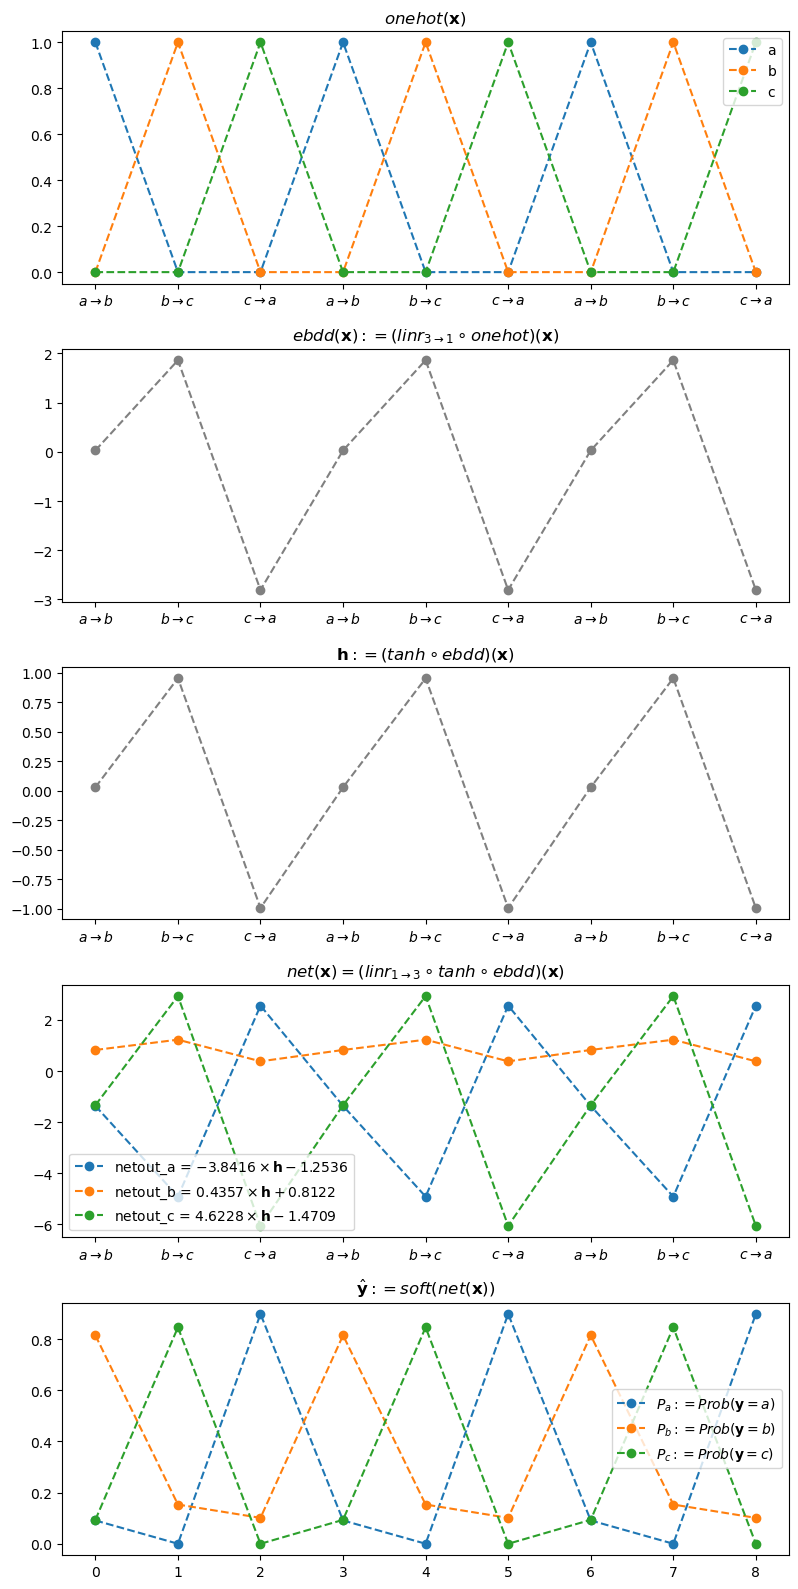

In [1599]:
fig, ax = plt.subplots(5,1,figsize=(8,16))
ax[0].plot(onehot_a,'--o',label='a')
ax[0].plot(onehot_b,'--o',label='b')
ax[0].plot(onehot_c,'--o',label='c')
ax[0].legend()
ax[0].set_title(r"$onehot({\bf x})$")
ax[0].set_xticks(range(9),[r'$a\to b$',r'$b \to c$',r'$c \to a$']*3)
ax[1].plot(ebdd_x,'--o',color="gray")
ax[1].set_title(r"$ebdd({\bf x}):=(linr_{3\to 1} \circ onehot)({\bf x})$")
ax[1].set_xticks(range(9),[r'$a\to b$',r'$b \to c$',r'$c \to a$']*3);
ax[2].plot(h,'--o',color="gray")
ax[2].set_title(r"${\bf h}:=(tanh\circ ebdd)({\bf x})$");
ax[2].set_xticks(range(9),[r'$a\to b$',r'$b \to c$',r'$c \to a$']*3);
ax[3].plot(netout_a,'--o',label=r"netout_a = $-3.8416\times {\bf h} - 1.2536$")
ax[3].plot(netout_b,'--o',label=r"netout_b = $0.4357\times {\bf h} + 0.8122$")
ax[3].plot(netout_c,'--o',label=r"netout_c = $4.6228\times {\bf h} - 1.4709$")
ax[3].set_xticks(range(9),[r'$a\to b$',r'$b \to c$',r'$c \to a$']*3);
ax[3].legend()
ax[3].set_title(r"$net({\bf x})=(linr_{1\to 3} \circ tanh \circ ebdd)({\bf x})$");
ax[4].plot(yhat_a,'--o',label=r'$P_a:=Prob({\bf y} =a)$')
ax[4].plot(yhat_b,'--o',label=r'$P_b:=Prob({\bf y} =b)$')
ax[4].plot(yhat_c,'--o',label=r'$P_c:=Prob({\bf y} =c)$')
ax[4].legend()
ax[4].set_title(r"$\hat{{\bf y}}:=soft(net({\bf x}))$");
ax[2].set_xticks(range(9),[r'$a\to b$',r'$b \to c$',r'$c \to a$']*3);
plt.tight_layout()

`-` 다른방식의 시각화

/tmp/ipykernel_247783/4245373420.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

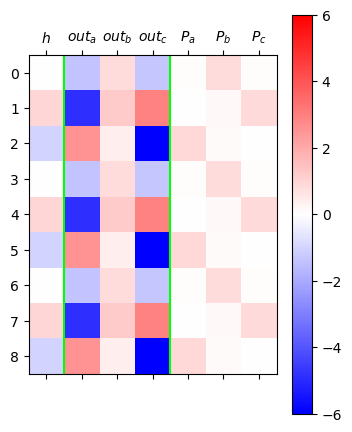

In [1602]:
h = tanh(ebdd(x)).data[:9]
netout = linr(tanh(ebdd(x))).data[:9]
yhat = soft(net(x)).data[:9]
mat = torch.concat([h,netout,yhat],axis=1)
#---#
plt.matshow(mat,cmap='bwr',vmin=-6,vmax=6)
plt.axvline(0.5,color="lime")
plt.axvline(3.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6],labels=[r'$h$',r'$out_a$',r'$out_b$',r'$out_c$',r'$P_a$',r'$P_b$',r'$P_c$'])
plt.colorbar()
plt.tight_layout()

-   netout 을 보는 요령: 가장 빨간부분이 예측값이 된다.
-   역시 $out_b$의 경우 애매한 색깔만 있음. (가장 빨갛다기 보다 다른게
    파란색이 나와줘서 정답을 맞추는 느낌)
-   그런데 $out_b$의 경우에 대응하는 ${\boldsymbol h}$를 살펴보니
    흰색임. 이것은 값이 0이라는 의미인데 이때는 ${\boldsymbol h}$ 에
    걸리는 선형변환 $linr_{1 \to 3}$ 의 weight 가 의미없고 bias만
    의미있기 때문에 특징을 잡기에 불리하다.
-   따라서 ${\boldsymbol h}$가 확실한 색을 가지고 있는것이 유리함.
    그렇지만 확실한 색인 빨강 파랑은 이미 차지된 상태라서 어쩔수 없이
    0이 선택된 것..

## D. MLP – 두개의 은닉노드

`-` 적합

In [1523]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=3,embedding_dim=2),
    torch.nn.Tanh(), # 이거 씁시당. 외우세여
    torch.nn.Linear(in_features=2,out_features=3),
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [1524]:
for epoc in range(50):
    ## 1
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

In [1525]:
h = net[:2](x).data[:9]
nout = net(x).data[:9]
yhat = soft(net(x)).data[:9]
mat = torch.concat([h,nout,yhat],axis=1)

/tmp/ipykernel_247783/3581487652.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

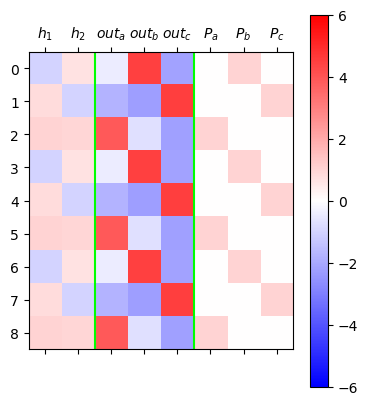

In [1526]:
plt.matshow(mat,cmap='bwr',vmin=-6,vmax=6)
plt.axvline(1.5,color="lime")
plt.axvline(4.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7],labels=[r'$h_1$',r'$h_2$',r'$out_a$',r'$out_b$',r'$out_c$',r'$P_a$',r'$P_b$',r'$P_c$'])
plt.colorbar()
plt.tight_layout()

`-` 시각화결과해석: 깔끔함. netout의 가장 빨간부분도 너무 명확함.
${\boldsymbol h}$가 0이 아닌 값으로 학습되어있음

-   h = (파,빨) =\> y=b
-   h = (빨,파) =\> y=c
-   h = (빨,빨) =\> y=b
-   h = (파,파) =\> 안썼음. y=d가 있었다면 거기 썻을듯

# 4. `abcd`

## A. Data

In [1608]:
txt = list('abcd')*100
txt[:10]

In [1609]:
df_train = pd.DataFrame({'x':txt[:-1],'y':txt[1:]})
df_train[:5]

In [1611]:
x = torch.tensor(df_train.x.map({'a':0, 'b':1, 'c':2, 'd':3}))
y = torch.tensor(df_train.y.map({'a':0, 'b':1, 'c':2, 'd':3}))

## B. MLP – 하나의 은닉노드

`-` 학습

In [1622]:
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=1),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=1,out_features=4)
)
ebdd,tanh,linr = net 
ebdd.weight.data = torch.tensor([[-0.3333],[-2.5000],[5.0000],[0.3333]])
linr.weight.data = torch.tensor([[1.5000],[-6.0000],[-2.0000],[6.0000]])
linr.bias.data = torch.tensor([0.1500, -2.0000,  0.1500, -2.000])
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [1645]:
for epoc in range(50):
    ## 1
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화1

In [1637]:
onehot_x = ohot(x).data[:8]
onehot_a = onehot_x[:,[0]]
onehot_b = onehot_x[:,[1]]
onehot_c = onehot_x[:,[2]]
onehot_d = onehot_x[:,[3]]
ebdd_x = ebdd(x).data[:8]
h = tanh(ebdd(x)).data[:8]
netout = linr(tanh(ebdd(x))).data[:8]
netout_a = netout[:,[0]]
netout_b = netout[:,[1]]
netout_c = netout[:,[2]]
netout_d = netout[:,[3]]
yhat = soft(net(x)).data[:8]
yhat_a = yhat[:,[0]]
yhat_b = yhat[:,[1]]
yhat_c = yhat[:,[2]]
yhat_d = yhat[:,[3]]

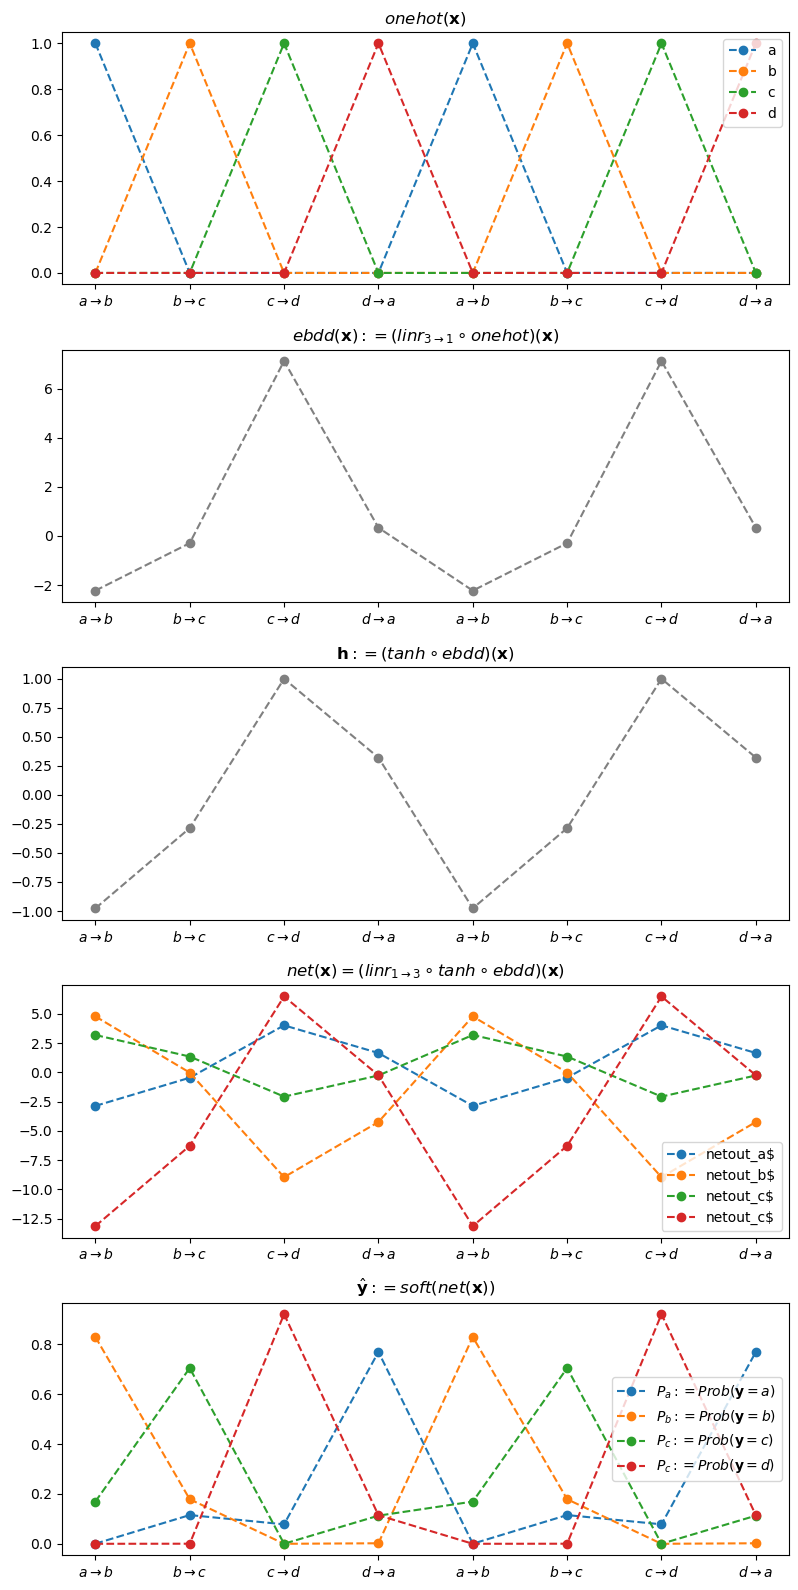

In [1638]:
fig, ax = plt.subplots(5,1,figsize=(8,16))
ax[0].plot(onehot_a,'--o',label='a')
ax[0].plot(onehot_b,'--o',label='b')
ax[0].plot(onehot_c,'--o',label='c')
ax[0].plot(onehot_d,'--o',label='d')
ax[0].legend()
ax[0].set_title(r"$onehot({\bf x})$")
ax[0].set_xticks(range(8),[r'$a\to b$',r'$b \to c$',r'$c \to d$', r'$d \to a$']*2)
ax[1].plot(ebdd_x,'--o',color="gray")
ax[1].set_title(r"$ebdd({\bf x}):=(linr_{3\to 1} \circ onehot)({\bf x})$")
ax[1].set_xticks(range(8),[r'$a\to b$',r'$b \to c$',r'$c \to d$', r'$d \to a$']*2)
ax[2].plot(h,'--o',color="gray")
ax[2].set_title(r"${\bf h}:=(tanh\circ ebdd)({\bf x})$");
ax[2].set_xticks(range(8),[r'$a\to b$',r'$b \to c$',r'$c \to d$', r'$d \to a$']*2)
ax[3].plot(netout_a,'--o',label=r"netout_a$")
ax[3].plot(netout_b,'--o',label=r"netout_b$")
ax[3].plot(netout_c,'--o',label=r"netout_c$")
ax[3].plot(netout_d,'--o',label=r"netout_c$")
ax[3].set_xticks(range(8),[r'$a\to b$',r'$b \to c$',r'$c \to d$', r'$d \to a$']*2)
ax[3].legend()
ax[3].set_title(r"$net({\bf x})=(linr_{1\to 3} \circ tanh \circ ebdd)({\bf x})$");
ax[4].plot(yhat_a,'--o',label=r'$P_a:=Prob({\bf y} =a)$')
ax[4].plot(yhat_b,'--o',label=r'$P_b:=Prob({\bf y} =b)$')
ax[4].plot(yhat_c,'--o',label=r'$P_c:=Prob({\bf y} =c)$')
ax[4].plot(yhat_d,'--o',label=r'$P_c:=Prob({\bf y} =d)$')
ax[4].legend()
ax[4].set_title(r"$\hat{{\bf y}}:=soft(net({\bf x}))$");
ax[4].set_xticks(range(8),[r'$a\to b$',r'$b \to c$',r'$c \to d$', r'$d \to a$']*2)
plt.tight_layout()

`-` 결과시각화2

In [1639]:
h = net[:2](x).data[:9]
nout = net(x).data[:9]
yhat = soft(net(x)).data[:9]
mat = torch.concat([h,nout,yhat],axis=1)

/tmp/ipykernel_247783/1444325948.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

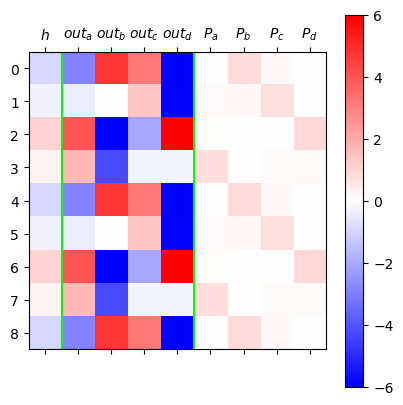

In [1643]:
plt.matshow(mat,cmap='bwr',vmin=-6,vmax=6)
plt.axvline(0.5,color="lime")
plt.axvline(4.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8],labels=[r'$h$',r'$out_a$',r'$out_b$',r'$out_c$',r'$out_d$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_d$'])
plt.colorbar()
plt.tight_layout()

-   out에서 제일 빨간색.. -\> 찾기 어렵죠??

## C. MLP – 두개의 은닉노드

`-` 학습

In [1652]:
torch.manual_seed(43052)
net = torch.nn.Sequential(
    torch.nn.Embedding(num_embeddings=4,embedding_dim=2),
    torch.nn.Tanh(),
    torch.nn.Linear(in_features=2,out_features=4)
)
loss_fn = torch.nn.CrossEntropyLoss()
optimizr = torch.optim.Adam(net.parameters(),lr=0.1)

In [1653]:
for epoc in range(50):
    ## 1
    netout = net(x)
    ## 2 
    loss = loss_fn(netout,y)
    ## 3 
    loss.backward()
    ## 4 
    optimizr.step()
    optimizr.zero_grad()

`-` 결과시각화

In [1654]:
h = net[:2](x).data[:9]
nout = net(x).data[:9]
yhat = soft(net(x)).data[:9]
mat = torch.concat([h,nout,yhat],axis=1)

/tmp/ipykernel_247783/2843776862.py:6: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()

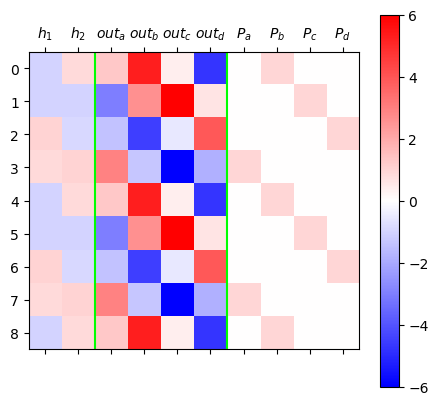

In [1657]:
plt.matshow(mat,cmap='bwr',vmin=-6,vmax=6)
plt.axvline(1.5,color="lime")
plt.axvline(5.5,color="lime")
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[r'$h_1$',r'$h_2$',r'$out_a$',r'$out_b$',r'$out_c$',r'$out_d$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_d$'])
plt.colorbar()
plt.tight_layout()

## D. 비교실험

In [1660]:
class MLP1(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,1)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(1,4)        
        ## 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h) 
        ## 정의 끝
        return netout

In [1659]:
class MLP2(torch.nn.Module):
    def __init__(self):
        super().__init__()
        ## 우리가 yhat을 구할때 사용할 레이어를 정의 
        self.ebdd = torch.nn.Embedding(4,2)
        self.tanh = torch.nn.Tanh()
        self.linr = torch.nn.Linear(2,4)        
        ## 정의 끝
    def forward(self,x):
        ## yhat을 어떻게 구할것인지 정의 
        ebdd_x = self.ebdd(x)
        h = self.tanh(ebdd_x)
        netout = self.linr(h) 
        ## 정의 끝
        return netout

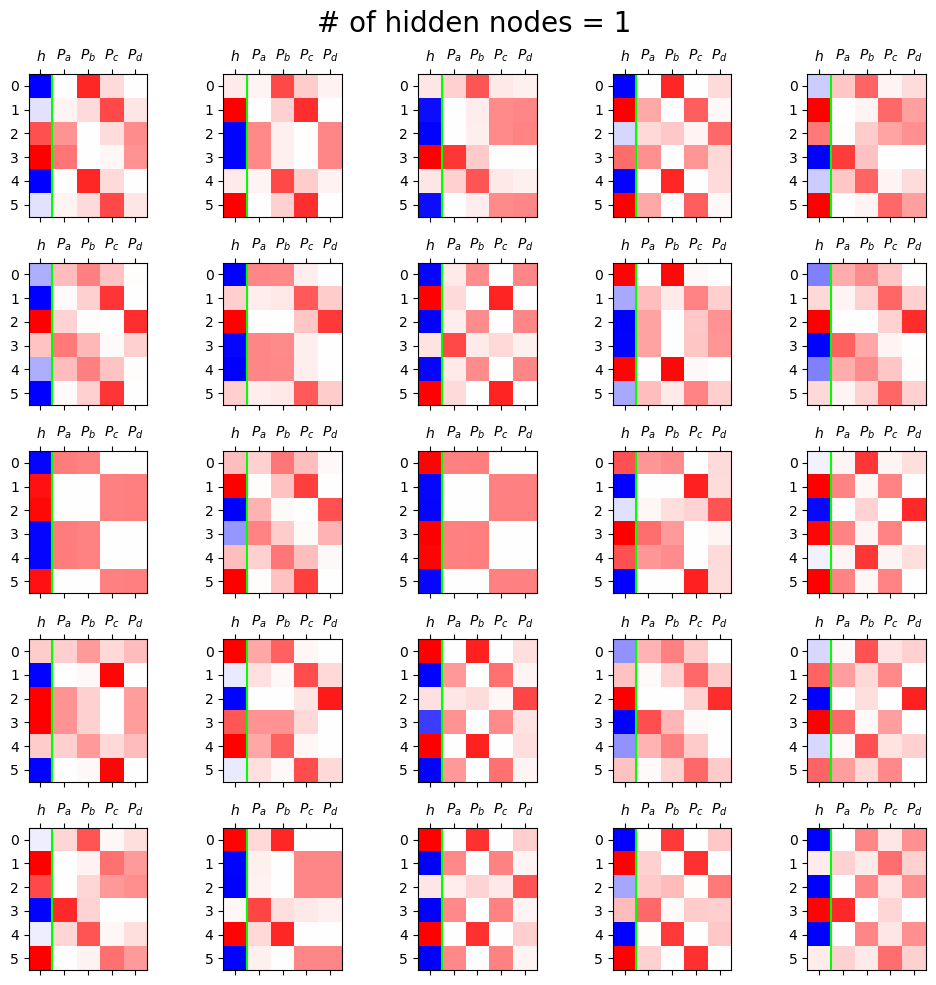

In [1692]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = MLP1()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        for epoc in range(50):
            ## 1
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data[:6]
        yhat=soft(net(x)).data[:6]
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat,cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(0.5,color="lime")
        ax[i][j].set_xticks(ticks=[0,1,2,3,4],labels=[r'$h$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("# of hidden nodes = 1",size=20)
fig.tight_layout()

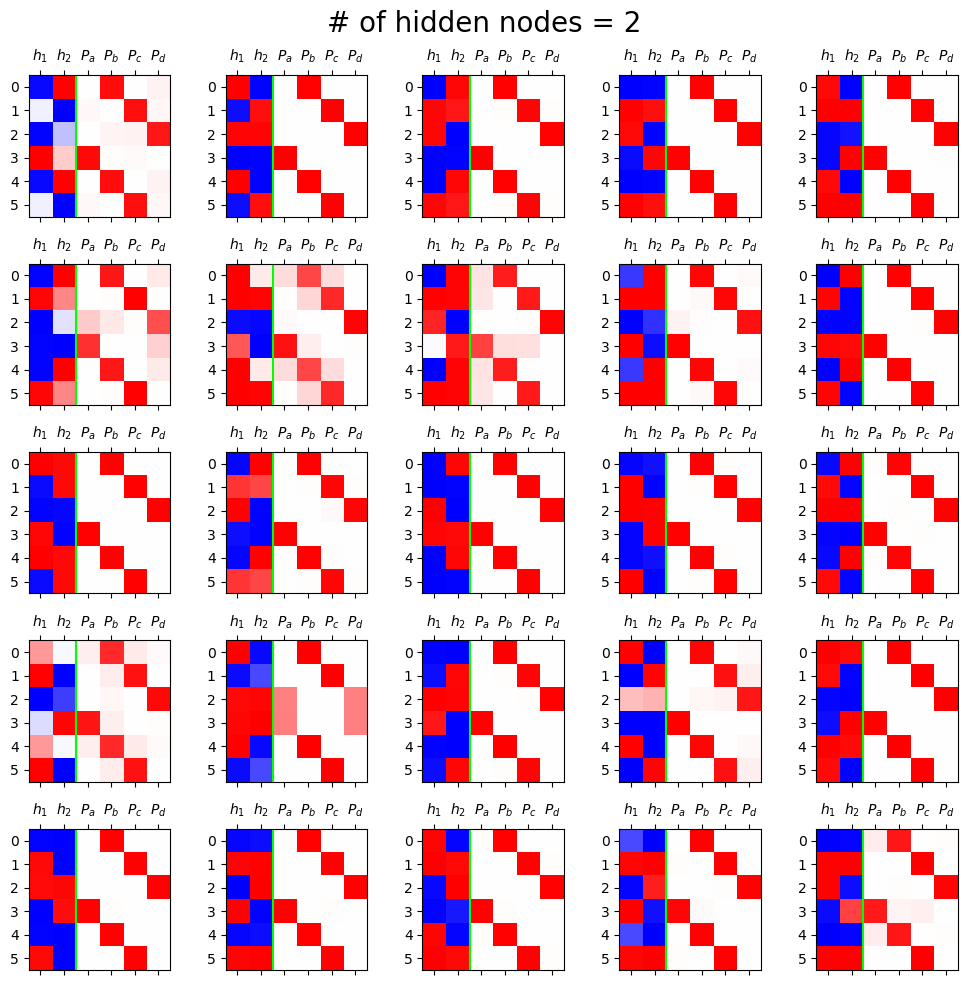

In [1691]:
fig, ax = plt.subplots(5,5,figsize=(10,10))
for i in range(5):
    for j in range(5):
        net = MLP2()
        optimizr = torch.optim.Adam(net.parameters(),lr=0.1)
        for epoc in range(50):
            ## 1
            netout = net(x)
            ## 2 
            loss = loss_fn(netout,y)
            ## 3 
            loss.backward()
            ## 4 
            optimizr.step()
            optimizr.zero_grad()
        h = net.tanh(net.ebdd(x)).data[:6]
        yhat=soft(net(x)).data[:6]
        mat = torch.concat([h,yhat],axis=1)
        ax[i][j].matshow(mat,cmap='bwr',vmin=-1,vmax=1)
        ax[i][j].axvline(1.5,color="lime")
        ax[i][j].set_xticks(ticks=[0,1,2,3,4,5],labels=[r'$h_1$',r'$h_2$',r'$P_a$',r'$P_b$',r'$P_c$',r'$P_d$'])
fig.suptitle("# of hidden nodes = 2",size=20)
fig.tight_layout()

# 5. ${\boldsymbol h}$ 에 대하여 $(\star\star\star$)

`-` ${\boldsymbol h}$는 사실 문자열 “abcd”들을 숫자로 바꾼 표현이라
해석할 수 있음. 즉 원핫인코딩과 다른 또 다른 형태의 숫자표현이라 해석할
수 있다.

`-` 사실 ${\boldsymbol h}$는 원핫인코딩보다 약간 더 (1) 액기스만 남은
느낌 + (2) 숙성된 느낌을 준다

-   (why1) ${\boldsymbol h}$는 ${\boldsymbol x}$ 보다
    ${\boldsymbol y}$를 예측함에 좀 더 직접적인 역할을 한다. 즉
    ${\boldsymbol x}$ 숫자보다 ${\boldsymbol h}$ 숫자가 잘 정리되어 있고
    (차원이 낮고) 입력의 특징을 잘 정리한 (추천시스템의 MBTI처럼)
    의미있는 숫자이다.
-   (why2) ${\boldsymbol x}$는 학습없이 그냥 얻어지는 숫자표현이지만,
    ${\boldsymbol h}$는 학습을 통하여 고치고 고치고 고친 숫자표현이다.

# A1. 파이토치의 정밀도

In [1269]:
a = torch.tensor(3.84157)
a

In [1271]:
b = torch.tensor(3.8416)
b

In [1273]:
a,b # a와 b는 같아보이지만 다르다.

In [1274]:
a - 0.00003 

In [1275]:
b - 0.00003